# Project No. 3: Average Temperatures 1995-2019

This exploratory analysis looks at global temperatures between 1995 and 2019 and explores Europe and Austria in more detail.

Data from: https://www.kaggle.com/sudalairajkumar/daily-temperature-of-major-cities

## Import

In [126]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import numpy as np
from tqdm import tqdm_notebook as tqdm
import datetime
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [9]:
df = pd.read_csv("city_temperature.csv", low_memory = False)

## Memory usage

Having a first look at the dataframe, I see that there's information about the region, country, state (in case of the US), city, date and average temperatuer (in Fahrenheit). 

In [8]:
df.sample(5)

,Region,Country,State,City,Month,Day,Year,AvgTemperature
183808,Africa,Senegal,NaN,Dakar,1,26,1999,67.0
1900635,North America,US,Indiana,South Bend,12,13,2005,23.4
2741831,North America,US,Texas,San Antonio,10,23,2019,68.3
2353242,North America,US,North Carolina,Raleigh Durham,9,3,2011,77.9
1619219,North America,US,Colorado,Denver,8,2,2002,70.3


I noticed that my computer takes quite a while to process the dataframe,so I have a look at its memory usage.

In [10]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2906327 entries, 0 to 2906326
Data columns (total 8 columns):
Region            object
Country           object
State             object
City              object
Month             int64
Day               int64
Year              int64
AvgTemperature    float64
dtypes: float64(1), int64(3), object(4)
memory usage: 767.7 MB


In [11]:
df.memory_usage(deep=True)

Index                    80
Region            200858229
Country           179884611
State             141323998
City              189912136
Month              23250616
Day                23250616
Year               23250616
AvgTemperature     23250616
dtype: int64

Since the dataframe takes 767.7 MB and has almost 3 million rows, I decide to decrease its memory usage in order to be able to work with it a little bit faster.

First, I convert the data type of some of the columns. Month and Day are converted from int64 to int 8 (as they only take on a max. value of 12 and 31, respectively), Year is converted from int64 to int16 (only takes on a max. values of 2020), and AvgTemperature is converted from float64 to float16.

In [14]:
df[['Month', 'Day']] = df[['Month', 'Day']].astype('int8')
df[['Year']] = df[['Year']].astype('int16')
df['AvgTemperature'] = df['AvgTemperature'].astype('float16')

In [15]:
df.reset_index(drop=True, inplace=True)

In [16]:
df.sample(5)

,Region,Country,State,City,Month,Day,Year,AvgTemperature
1431723,South/Central America & Carribean,Suriname,NaN,Paramaribo,5,9,2018,-99.00000
1674652,North America,US,District of Columbia,Washington,10,11,2011,66.81250
2846116,North America,US,West Virginia,Elkins,12,6,2000,21.59375
1500320,North America,US,Alaska,Fairbanks,3,25,2003,13.50000
1596990,North America,US,California,San Diego,10,28,2017,67.81250


In [17]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2906327 entries, 0 to 2906326
Data columns (total 8 columns):
Region            object
Country           object
State             object
City              object
Month             int8
Day               int8
Year              int16
AvgTemperature    float16
dtypes: float16(1), int16(1), int8(2), object(4)
memory usage: 695.6 MB


In [18]:
df.memory_usage(deep=True)

Index                    80
Region            200858229
Country           179884611
State             141323998
City              189912136
Month               2906327
Day                 2906327
Year                5812654
AvgTemperature      5812654
dtype: int64

## Data cleaning


First of all, there are some ambiguous year values in the dataframe, so I drop them. I also drop all data from the year 2020, since there is no data available for the whole year yet.

In [20]:
df = df[df.Year != 200]
df = df[df.Year != 201]
df = df[df.Year != 2020]

I also drop the column State, since it only applies to the US, which I don't want to analyze in detail.

In [21]:
df = df.drop('State', axis = 1)

Next, I create a separate datetime column. However, I leave out the Day column since I do not need to work with daily temperatures. Monthly temperatures are fine and will save me some computational cost with certain plots.

In [22]:
# make date column
df['Date'] = pd.to_datetime(df.Year.astype(str) + '/' + df.Month.astype(str))

To handle any missing data, I first look at what percentage of data is missing for each country.

In [43]:
missing = pd.DataFrame(df.loc[df.AvgTemperature == -99, 'Country'].value_counts())
missing['TotalData'] = df.groupby('Country').AvgTemperature.count()
missing['PercentageMissing'] = missing.apply(lambda row: (row.Country/row.TotalData)*100, axis = 1)
missing.sort_values(by=['PercentageMissing'], inplace=True, ascending = False)
missing.head(20)

,Country,TotalData,PercentageMissing
Burundi,3659,4543,80.541492
Guyana,2929,5065,57.828233
Malawi,3052,5693,53.609696
Sierra Leone,3145,6209,50.652279
Guinea-Bissau,4083,9133,44.706011
Bangladesh,2243,5810,38.605852
Haiti,3451,9135,37.777778
Oman,2993,8917,33.565100
Germany,6977,24384,28.613025
Kenya,2139,8037,26.614408


It looks like there is a lot of data missing in Burundi, as well as in some other African, Latin American, Asian and European countries.

Since any missing temperatures are saved as -99, I convert them to NaN.

In [46]:
df.loc[df.AvgTemperature == -99, 'AvgTemperature'] = np.nan

In [47]:
df.AvgTemperature.isna().sum()

79164

I then fill the missing values with the mean temperature of the same city and of the same date every year.

In [53]:
df['AvgTemperature'] = df['AvgTemperature'].fillna(df.groupby(['City', 'Date']).AvgTemperature.transform('mean'))

In [54]:
df.AvgTemperature.isna().sum()

25627

However, it seems that for some cities, there is so much data missing, that they may not be any recorded temperature for a given date.

In [55]:
df.loc[df.AvgTemperature.isna(), 'City'].value_counts()

Bissau                  3014
Bujumbura               2401
Muscat                  2285
Freetown                2159
Lilongwe                1709
Georgetown              1397
Tirana                  1127
Port au Prince          1034
Nicosia                  853
Nairobi                  760
Addis Ababa              732
Conakry                  610
Guadalajara              608
Dusanbe                  486
Jakarta                  426
Kampala                  425
Zagreb                   396
Lagos                    367
Sofia                    366
Bangkok                  365
Rangoon                  365
Paramaribo               275
Frankfurt                274
Banjul                   273
Managua                  242
Bonn                     214
Santo Domingo            211
Tbilisi                  184
Tel Aviv                 182
Islamabad                182
Brazzaville              154
Guatemala City           150
Libreville               124
Maputo                   123
Perth         

So for those cities, I fill the missing data with the overall mean temperature of the city

In [56]:
df['AvgTemperature'] = df['AvgTemperature'].fillna(df.groupby(['City']).AvgTemperature.transform('mean'))

In [57]:
df.AvgTemperature.isna().sum()

0

Since I have a better intuition for temperatures in Celsius, I convert them.

In [60]:
# °F to °C: (°F − 32) × 5/9 = °C
df['AvgTempCelsius'] = (df.AvgTemp_filled2 -32)*(5/9)
df  = df.drop(['AverageTempearture'], axis = 1)

Finally, I round the temperatures in tow different way, once with two and once with one decimal.

In [62]:
df['AvgTempCelsius_rounded'] = df.AvgTempCelsius.apply(lambda x: "{0:0.2f}".format(x))
df['AvgTempCelsius_rounded2'] = df.AvgTempCelsius.apply(lambda x: "{0:0.1f}".format(x))

In [63]:
df['AvgTempCelsius_rounded'] = pd.to_numeric(df['AvgTempCelsius_rounded'])
df['AvgTempCelsius_rounded2'] = pd.to_numeric(df['AvgTempCelsius_rounded2'])

In [64]:
df.sample(5)

,Region,Country,City,Month,Day,Year,Date,AvgTempCelsius,AvgTempCelsius_rounded,AvgTempCelsius_rounded2
328988,Asia,India,Calcutta,9,17,2014,2014-09-01,31.218750,31.22,31.2
482546,Asia,Philippines,Manila,10,17,2006,2006-10-01,27.406250,27.41,27.4
521957,Asia,Taiwan,Taipei,3,21,2013,2013-03-01,20.000000,20.00,20.0
1236287,South/Central America & Carribean,Argentina,Buenos Aires,3,20,2008,2008-03-01,21.593750,21.59,21.6
2092868,North America,US,Sault Ste Marie,1,21,2009,2009-01-01,-8.335938,-8.34,-8.3


Finally, I save the dataframe as a pickle in order to reload it quickly next time I want to work with it.

In [65]:
df.to_pickle('temperature_rise_ready.pkl')

## Analysis

### Global

In [2]:
df = pd.read_pickle('temperature_rise_ready.pkl')

In [4]:
df.sample(5)

,Region,Country,City,Month,Day,Year,Date,AvgTempCelsius,AvgTempCelsius_rounded,AvgTempCelsius_rounded2
2564945,North America,US,Charleston,6,25,2017,2017-06-01,26.734375,26.73,26.7
2717518,North America,US,Midland Odessa,12,23,2003,2003-12-01,5.730469,5.73,5.7
2378941,North America,US,Akron Canton,12,7,2005,2005-12-01,-9.218750,-9.22,-9.2
1057608,Middle East,Qatar,Doha,6,8,1999,1999-06-01,40.125000,40.12,40.1
1794184,North America,US,Macon,11,24,2018,2018-11-01,8.335938,8.34,8.3


#### YEARLY GLOBAL AVERAGE TEMPERATURE OVER TIME

/Users/Helene/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


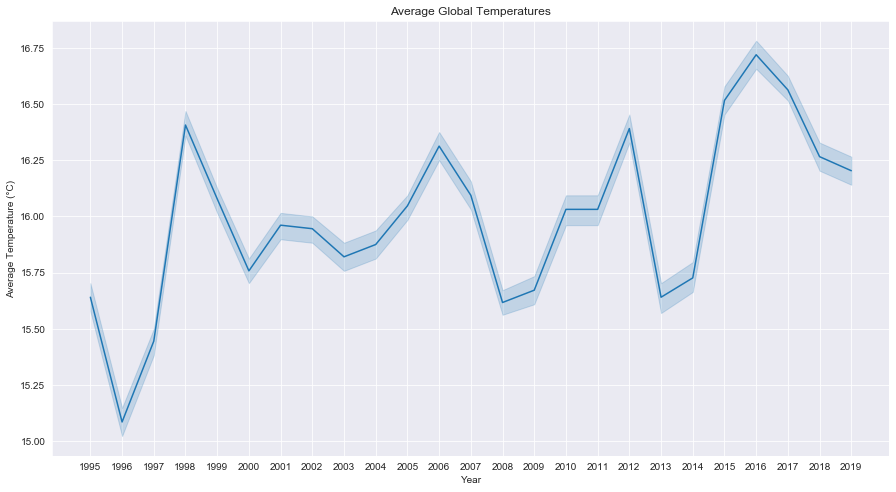

In [68]:
plt.figure(figsize=(15,8))
sns.lineplot(x = 'Year', y = 'AvgTempCelsius', data = df , palette='Set2')
plt.title('Average Global Temperatures')
plt.ylabel('Average Temperature (°C)')
plt.xlabel('Year')
plt.xticks(range(1995,2020))
plt.show();

#### MONTHLY GLOBAL AVERAGE TEMPERATURE OVER TIME

In [5]:
df_mean_month = df.groupby(['Month', 'Year']).AvgTempCelsius_rounded2.mean()
df_mean_month = df_mean_month.reset_index()
df_mean_month = df_mean_month.sort_values(by = ['Year'])

In [6]:
df_pivoted = pd.pivot_table(data= df_mean_month,
                    index='Month',
                    values='AvgTempCelsius_rounded2',
                    columns='Year')

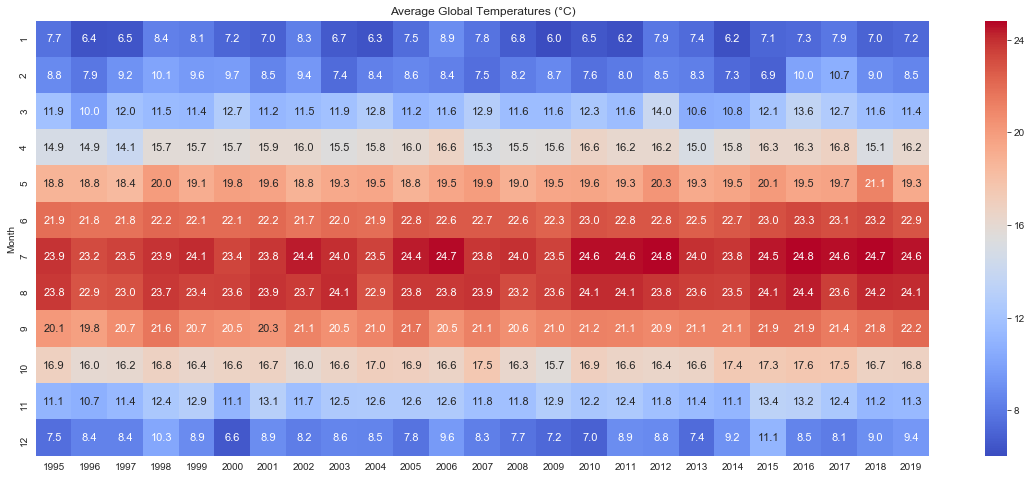

In [64]:
plt.figure(figsize=(20, 8))
sns.heatmap(data = df_pivoted, cmap='coolwarm', annot = True, fmt=".1f", annot_kws={'size':11})
plt.xlabel('')
plt.ylabel('Month')
plt.title('Average Global Temperatures (°C)')
plt.show();

#### AVERAGE TEMPERATURE OF DIFFERENT REGIONS

In [69]:
s = df.groupby(['Region'])['AvgTempCelsius'].mean().reset_index().sort_values(by='AvgTempCelsius',ascending=False)
s.style.background_gradient(cmap="RdBu_r")

,Region,AvgTempCelsius
0,Africa,23.6406
4,Middle East,23.4375
6,South/Central America & Carribean,22.5625
1,Asia,20.2344
2,Australia/South Pacific,16.7969
5,North America,13.5078
3,Europe,11.1875


#### AVERAGE TEMPERATURE OF DIFFERENT REGIONS OVER TIME

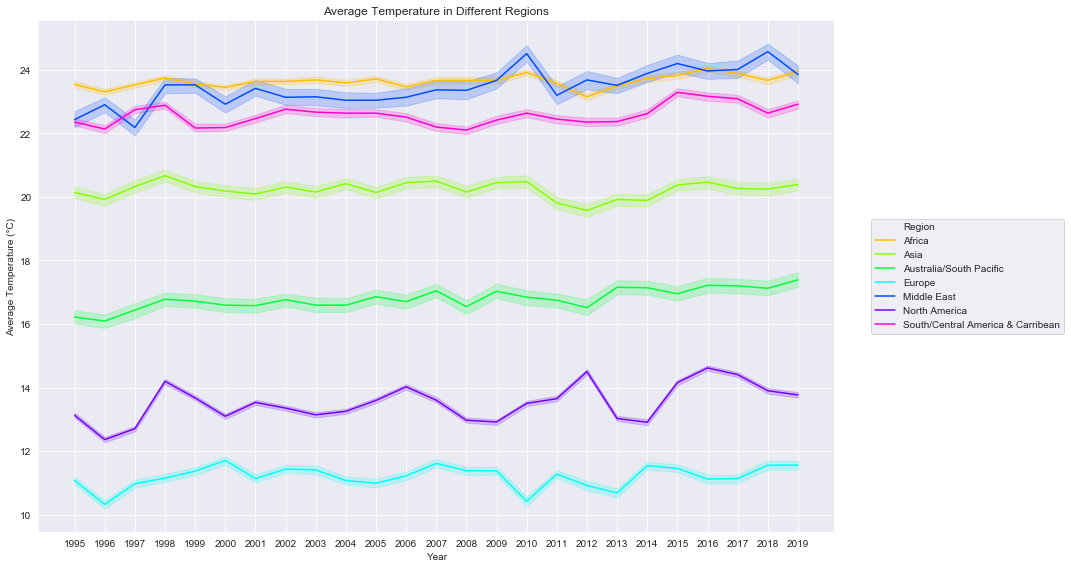

In [127]:
f = plt.figure(figsize=(15,8))
sns.lineplot(x = 'Year', y = 'AvgTempCelsius', hue = 'Region', data = df , palette='hsv')
plt.title('Average Temperature in Different Regions')
plt.ylabel('Average Temperature (°C)')
plt.xlabel('Year')
plt.xticks(range(1995,2020))
plt.legend(loc='center left', bbox_to_anchor=(1.04, 0.5),ncol=1)
plt.tight_layout()
plt.show();

#### DISTRIBUTION OF TEMPERATURES IN DIFFERENT REGIONS

In [4]:
continents_avg_temp_month = df.groupby(['Region', 'Date'])['AvgTempCelsius'].mean().reset_index()

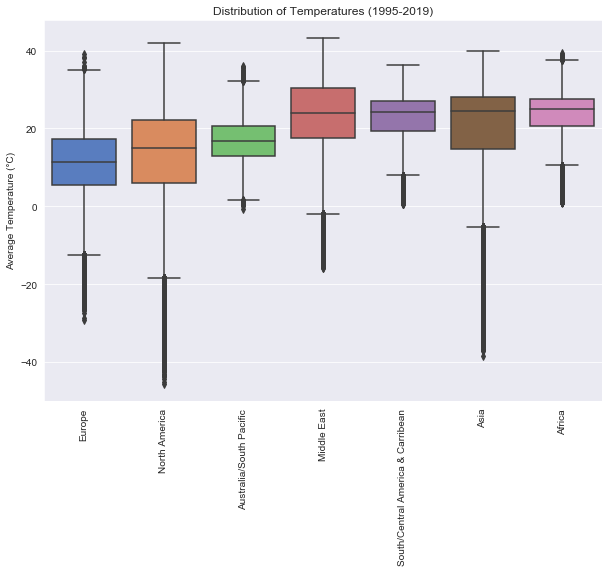

In [74]:
region_sorted = df.groupby('Region')['AvgTempCelsius'].median().sort_values().index

with sns.color_palette("muted"):
    f, ax = plt.subplots(figsize=(10, 7))
    sns.boxplot(data = df.sort_values("AvgTempCelsius"), x = 'Region', y = 'AvgTempCelsius', order = region_sorted)
    plt.xticks(rotation = 90)
    plt.title('Distribution of Temperatures (1995-2019)')
    plt.xlabel('')
    plt.ylabel('Average Temperature (°C)')

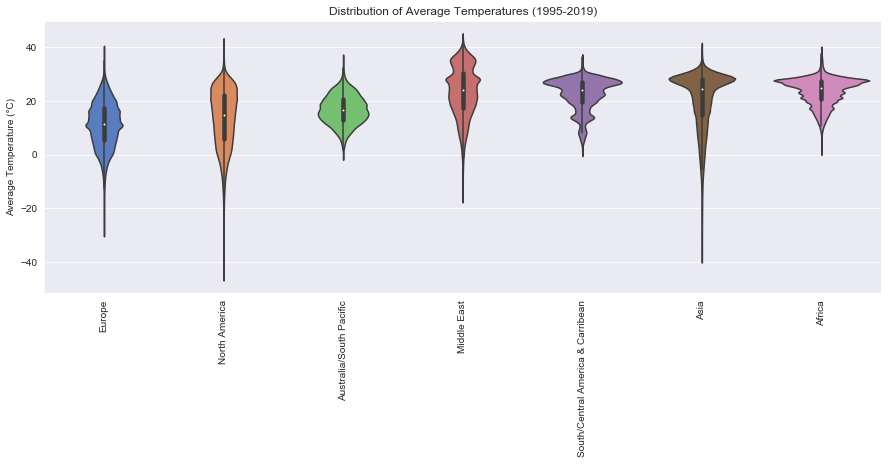

In [128]:
with sns.color_palette("muted"):
    f, ax = plt.subplots(figsize=(15, 5))
    sns.violinplot(data = df.sort_values("AvgTempCelsius"), x = 'Region', y = 'AvgTempCelsius_rounded', order = region_sorted)
    plt.xticks(rotation = 90)
    plt.title('Distribution of Average Temperatures (1995-2019)')
    plt.xlabel('')
    plt.ylabel('Average Temperature (°C)')
    plt.show;

#### MONTHLY AVERAGE TEMPERATURE IN DIFFERENT REGIONS

In [80]:
regions = df.Region.unique().tolist()

In [82]:
import matplotlib.gridspec as gridspec

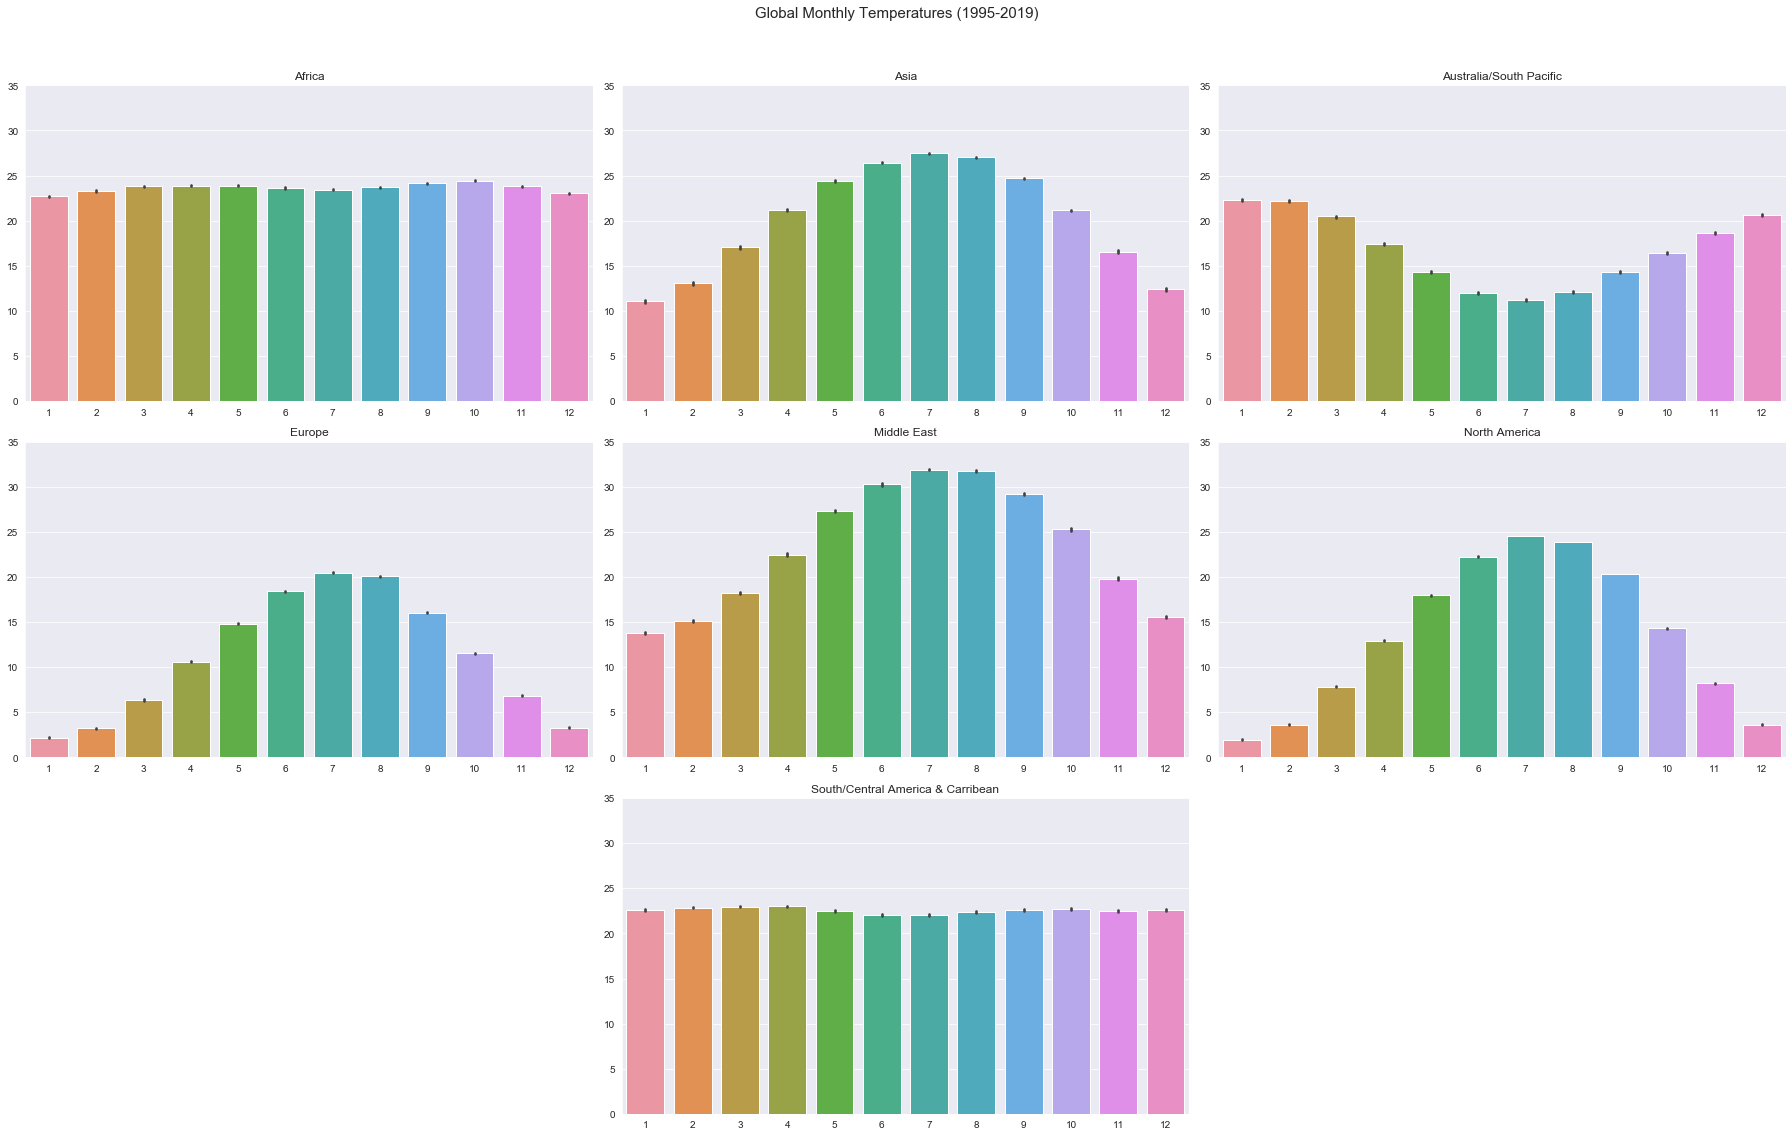

In [129]:
number_plot = [0, 0, 0, 1, 1, 1, 2]
position_a = [0, 2, 4, 0, 2, 4, 2]
position_b = [2, 4, 6, 2, 4, 6, 4]

fig = plt.figure(figsize = (25,15))
plt.suptitle('Global Monthly Temperatures (1995-2019)', y = 1.05, fontsize=15)

gs = gridspec.GridSpec(3, 6)

for i in range(7): 
    #ax = plt.subplot(3, 3, i+1)
    ax = plt.subplot(gs[number_plot[i], position_a[i]:position_b[i]])
    sns.barplot(x = 'Month', y = 'AvgTempCelsius_rounded2', data = df[df.Region == regions[i]])
    ax.title.set_text(regions[i])
    ax.set_ylim((0,35))
    ax.set_xlabel('')
    ax.set_ylabel('')

plt.subplots_adjust(wspace = 0.5)

plt.savefig('demographics.png')
plt.tight_layout()
plt.show();

#### TOP 10 HOTTEST COUNTRIES

In [70]:
s = df.groupby(['Country'])['AvgTempCelsius'].mean().reset_index().sort_values(by='AvgTempCelsius',ascending=False)[:10]
s.style.background_gradient(cmap="Reds")

,Country,AvgTempCelsius
44,Haiti,29.6875
108,Thailand,28.8438
78,Nigeria,28.7031
43,Guyana,28.5469
50,Indonesia,28.5469
117,United Arab Emirates,28.5312
88,Qatar,28.3906
81,Oman,28.3125
85,Philippines,27.9688
42,Guinea-Bissau,27.9531


#### TOP 10 COLDEST COUNTRIES

In [71]:
s = df.groupby(['Country'])['AvgTempCelsius'].mean().reset_index().sort_values(by='AvgTempCelsius',ascending=True)[:10]
s.style.background_gradient(cmap="Blues")

,Country,AvgTempCelsius
70,Mongolia,-0.826172
48,Iceland,5.34375
80,Norway,5.48438
18,Canada,5.89062
33,Finland,5.98047
62,Latvia,7.47266
14,Bolivia,7.48438
9,Belarus,7.49609
102,Sweden,7.60938
90,Russia,7.71484


### Europe

In [85]:
df_europe = df[df.Region == 'Europe'].copy()

In [36]:
df_europe.sample(5)

,Region,Country,City,Month,Day,Year,Date,AvgTempCelsius,AvgTempCelsius_rounded,AvgTempCelsius_rounded2,AvgTemp_nodecimal
849488,Europe,Norway,Oslo,9,17,2017,2017-09-01,10.554688,10.55,10.6,11.0
639578,Europe,Austria,Vienna,12,27,2013,2013-12-01,6.113281,6.11,6.1,6.0
788168,Europe,Ireland,Dublin,1,28,2003,2003-01-01,4.722656,4.72,4.7,5.0
941696,Europe,Switzerland,Bern,4,6,1998,1998-04-01,9.898438,9.90,9.9,10.0
643305,Europe,Belarus,Minsk,10,28,1998,1998-10-01,4.617188,4.62,4.6,5.0


#### DISTRIBUTION OF  TEMPERATURES IN EUROPE

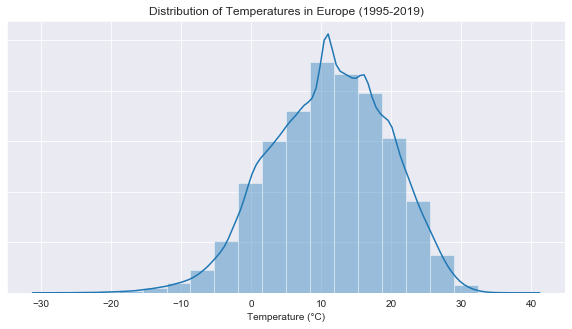

In [111]:
f, ax = plt.subplots(figsize=(10, 5))
sns.distplot(df_europe.AvgTempCelsius_rounded, bins = 20)
plt.title('Distribution of Temperatures in Europe (1995-2019)')
plt.xlabel('Temperature (°C)')
#ax.axes.yaxis.set_visible(False)
ax.axes.yaxis.set_ticklabels(['']);

#### DISTRIBUTION OF TEMPERATURES IN EUROPE IN 2019

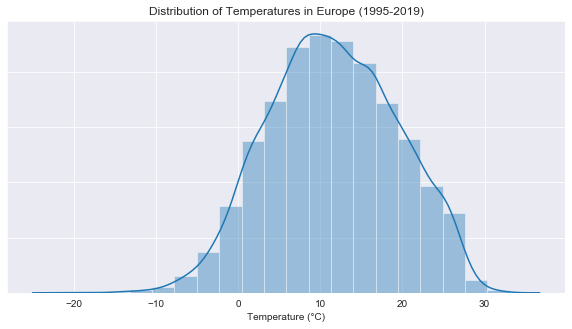

In [110]:
f, ax = plt.subplots(figsize=(10, 5))
sns.distplot(df_europe[df_europe.Year == 2019].AvgTempCelsius_rounded, bins = 20)
plt.title('Distribution of Temperatures in Europe (1995-2019)')
plt.xlabel('Temperature (°C)')
#ax.axes.yaxis.set_visible(False)
ax.axes.yaxis.set_ticklabels(['']);

#### DISTRIBUTION OF TEMPERATURES IN DIFFERENT EUROPEAN COUNTRIES

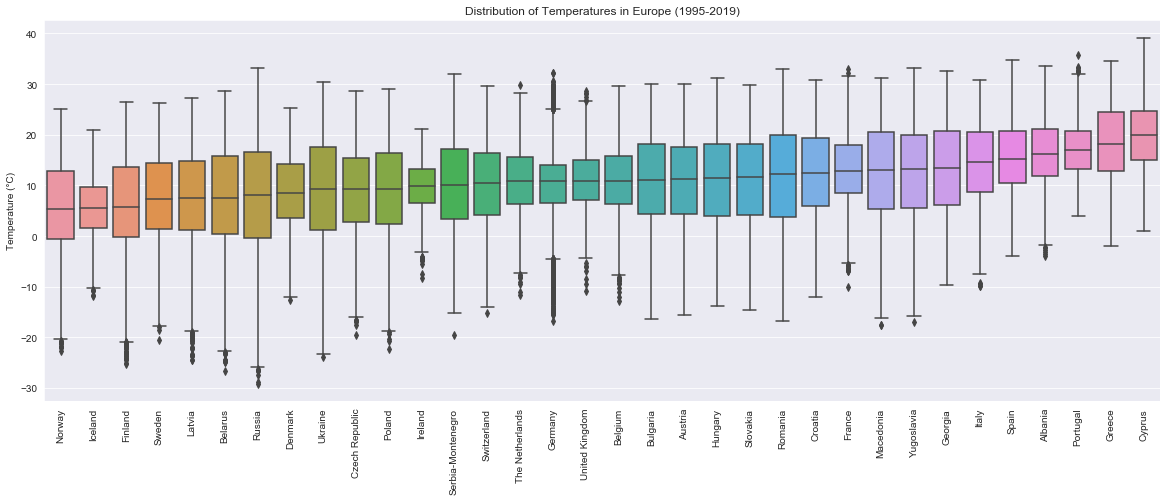

In [98]:
countries_sorted = df_europe.groupby('Country')['AvgTempCelsius_rounded2'].median().sort_values().index

with sns.color_palette("muted"):
    f, ax = plt.subplots(figsize=(20, 7))
    sns.boxplot(data = df_europe, x = 'Country', y = 'AvgTempCelsius_rounded', order = countries_sorted)
    plt.xticks(rotation = 90)
    plt.title('Distribution of Temperatures in Europe (1995-2019)')
    plt.ylabel('Temperature (°C)')
    plt.xlabel('');

#### AVERAGE TEMPERATURE IN DIFFERENT EUROPEAN COUNTRIES

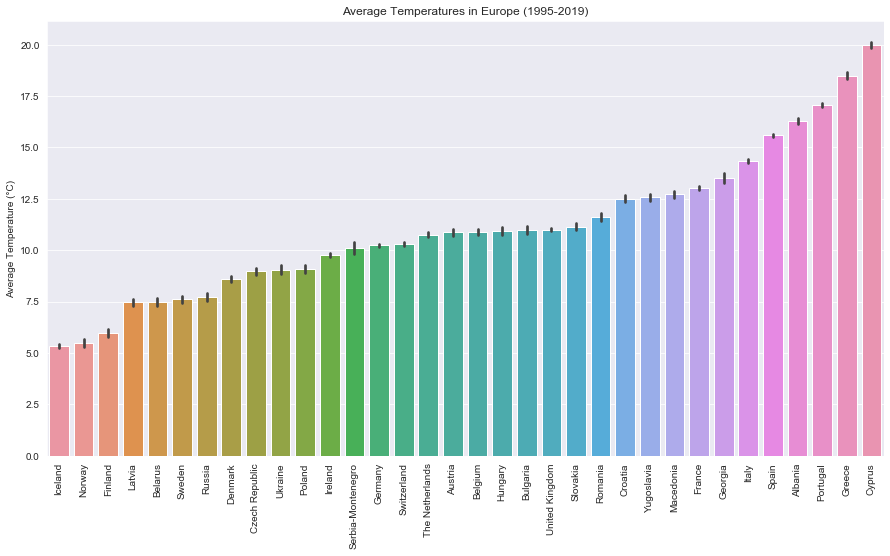

In [130]:
countries_mean_sorted = df_europe.groupby('Country').AvgTempCelsius_rounded2.mean().sort_values().index

plt.figure(figsize = (15,8))
sns.barplot(x = 'Country', y = 'AvgTempCelsius_rounded2', data = df_europe, 
            order = countries_mean_sorted)
plt.xticks(rotation = 90)
plt.xlabel('')
plt.title('Average Temperatures in Europe (1995-2019)')
plt.ylabel('Average Temperature (°C)');

#### AVERAGE TEMPERATURE IN EUROPE OVER TIME 

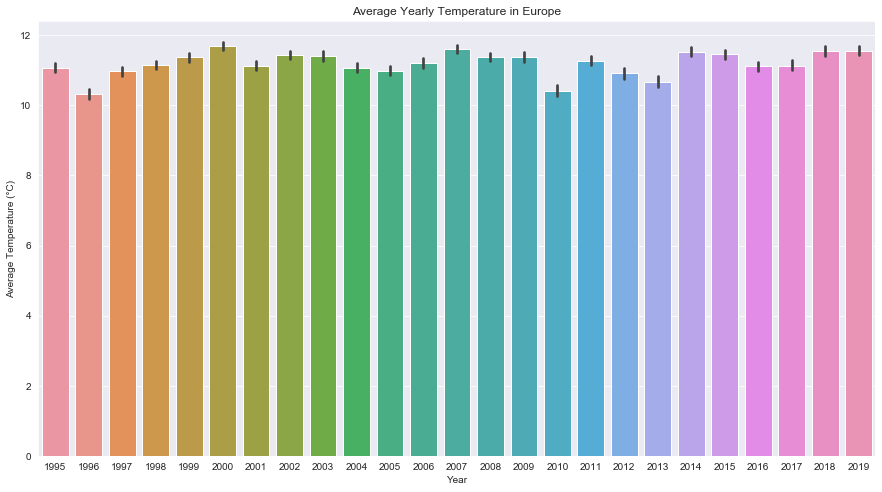

In [93]:
plt.figure(figsize = (15,8))
sns.barplot(x = 'Year', y = 'AvgTempCelsius_rounded2', data = df_europe)
plt.title('Average Yearly Temperature in Europe')
plt.xlabel('Year')
plt.ylabel('Average Temperature (°C)')
plt.show();

#### MONTHLY AVERAGE TEMPERATURE IN EUROPE OVER TIME

In [59]:
europe_mean_month = df_europe.groupby(['Month', 'Year']).AvgTempCelsius_rounded2.mean()
europe_mean_month = europe_mean_month.reset_index()
europe_mean_month = europe_mean_month.sort_values(by = ['Year'])

In [60]:
europe_pivoted = pd.pivot_table(data= europe_mean_month,
                    index='Month',
                    values='AvgTempCelsius_rounded2',
                    columns='Year')

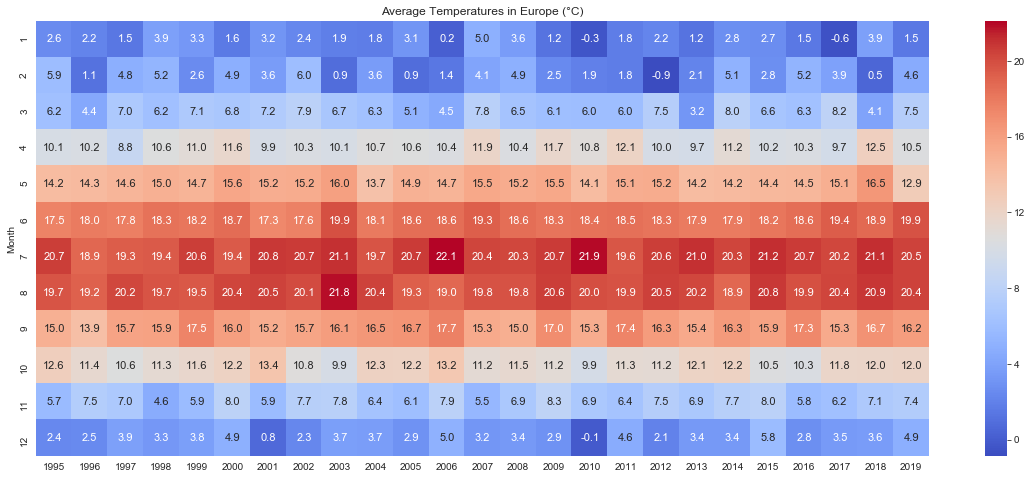

In [81]:
plt.figure(figsize=(20, 8))
sns.heatmap(data = europe_pivoted, cmap='coolwarm', annot = True, fmt=".1f", annot_kws={'size':11})
plt.ylabel('Month')
plt.xlabel('')
plt.title('Average Temperatures in Europe (°C)')
plt.show();

### Austria

In [104]:
df_austria = df_europe[df_europe.Country == 'Austria'].copy()

In [105]:
df_austria.head()

,Region,Country,City,Month,Day,Year,Date,AvgTempCelsius,AvgTempCelsius_rounded,AvgTempCelsius_rounded2,AvgTemp_nodecimal
632643,Europe,Austria,Vienna,1,1,1995,1995-01-01,2.048828,2.05,2.0,2.0
632644,Europe,Austria,Vienna,1,2,1995,1995-01-01,1.493164,1.49,1.5,1.0
632645,Europe,Austria,Vienna,1,3,1995,1995-01-01,-0.329834,-0.33,-0.3,-0.0
632646,Europe,Austria,Vienna,1,4,1995,1995-01-01,-3.777344,-3.78,-3.8,-4.0
632647,Europe,Austria,Vienna,1,5,1995,1995-01-01,-5.000000,-5.00,-5.0,-5.0


#### DISTRIBUTION OF TEMPERATURES IN AUSTRIA

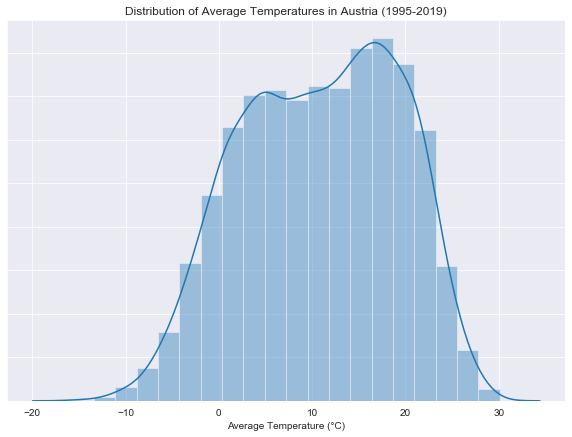

In [109]:
f, ax = plt.subplots(figsize=(10, 7))
sns.distplot(df_austria.AvgTempCelsius_rounded, bins = 20);
plt.title('Distribution of Average Temperatures in Austria (1995-2019)')
plt.xlabel('Average Temperature (°C)')
ax.axes.yaxis.set_ticklabels([]);

#### YEARLY AVERAGE TEMPERATURE IN AUSTRIA OVER TIME

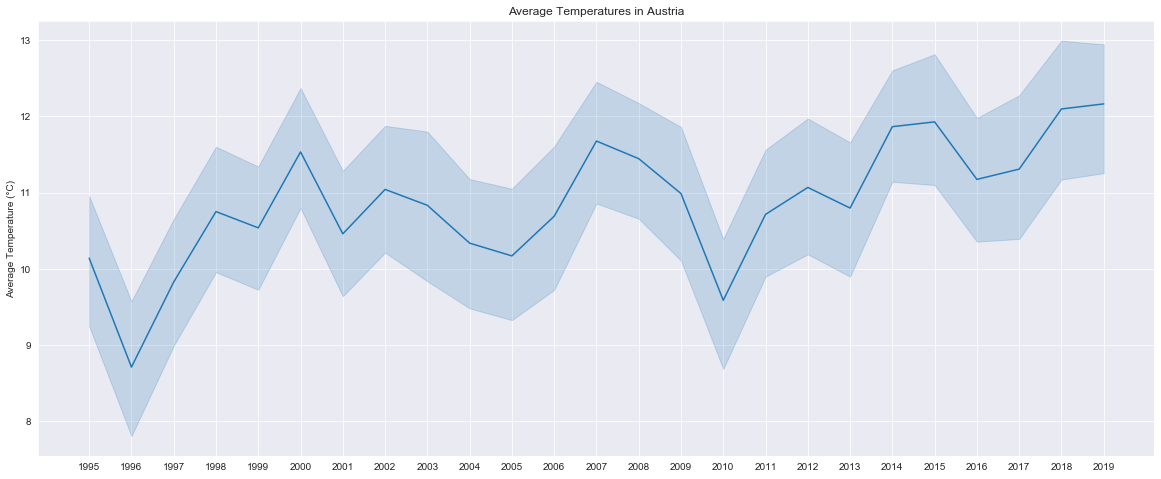

In [75]:
plt.figure(figsize=(20,8))
sns.lineplot(x = 'Year', y = 'AvgTempCelsius_rounded2', data = df_austria , palette='hsv')
plt.title('Average Temperatures in Austria')
plt.ylabel('Average Temperature (°C)')
plt.xlabel('')
plt.xticks(range(1995,2020))
plt.show()

#### MONTHLY AVERAGE TEMPERATURE IN AUSTRIA

In [113]:
years = df_austria.Year.unique().tolist()
years = [str(year) for year in years]

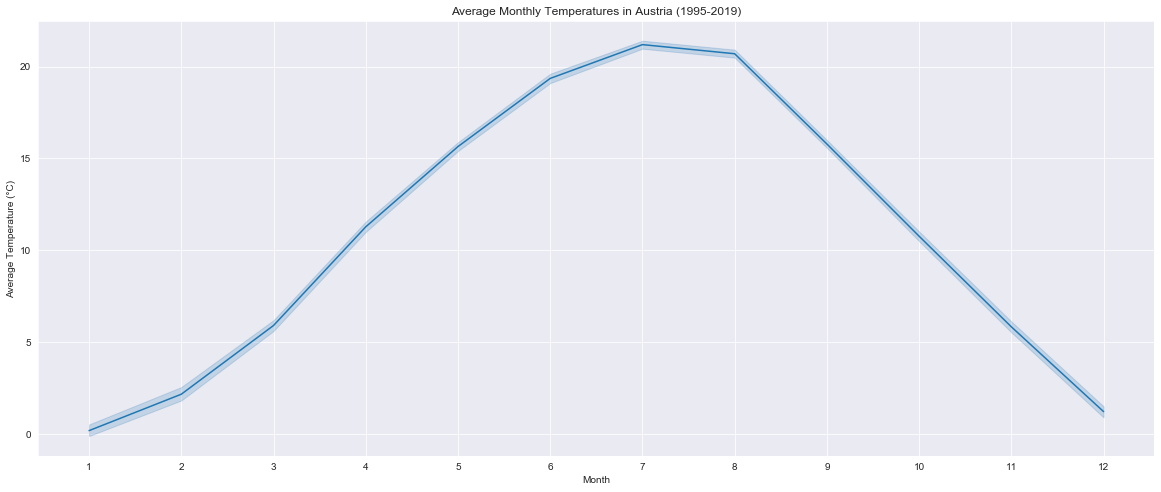

In [116]:
plt.figure(figsize=(20,8))
sns.lineplot(x = 'Month', y = 'AvgTempCelsius_rounded2', data = df_austria , palette='hsv')
plt.title('Average Monthly Temperatures in Austria (1995-2019)')
plt.ylabel('Average Temperature (°C)')
plt.xlabel('Month')
plt.xticks(range(1,13))
plt.show();

#### MONTHLY AVERAGE TEMPERATURE IN AUSTRIA (DETAILED)

In [123]:
months = ['January', 'February', 'March', 'April', 'May', 'June', 
          'July', 'August', 'September', 'October', 'November', 'December']

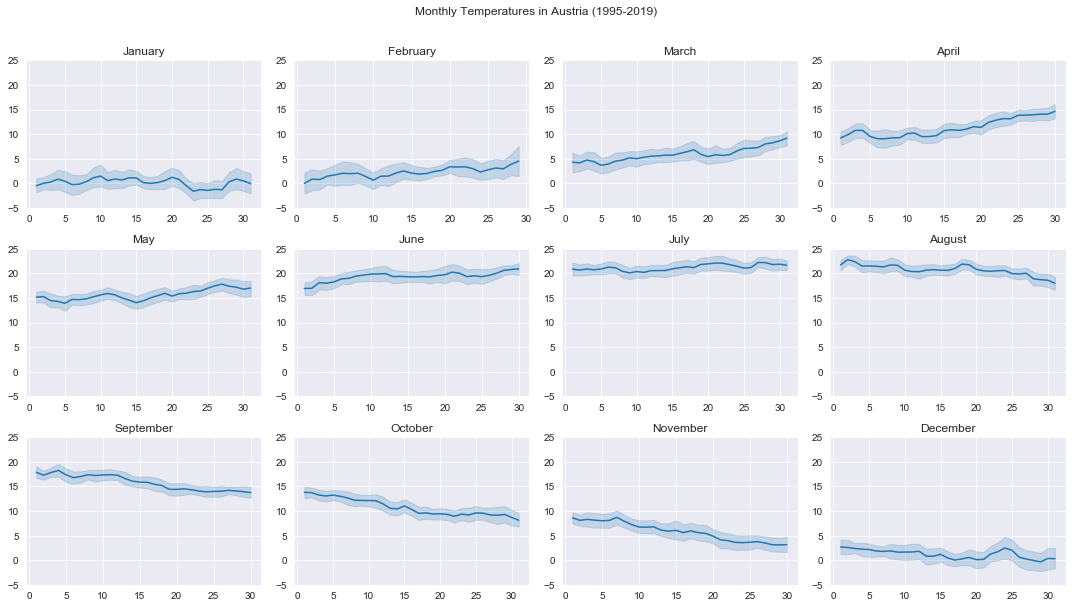

In [124]:
fig = plt.subplots(3,4, figsize = (15,8))
for i in range(1,13): 
    ax = plt.subplot(3, 4, i)
    sns.lineplot(x = 'Day', y = 'AvgTempCelsius_rounded2', data = df_austria[df_austria.Month == i] , palette='hsv')
    ax.title.set_text(months[i-1])
    ax.set_ylim((-5,25))
    ax.set_xlabel('')
    ax.set_ylabel('')
plt.suptitle('Monthly Temperatures in Austria (1995-2019)', y = 1.05)
#plt.ylabel('Average Temperature (°C)')
plt.tight_layout()
plt.show();

#### MONTHLY AVERAGE TEMPERATURE IN AUSTRIA OVER TIME

In [119]:
austria_pivoted = pd.pivot_table(data= df_austria,
                    index='Month',
                    values='AvgTempCelsius_rounded2',
                    columns='Year')

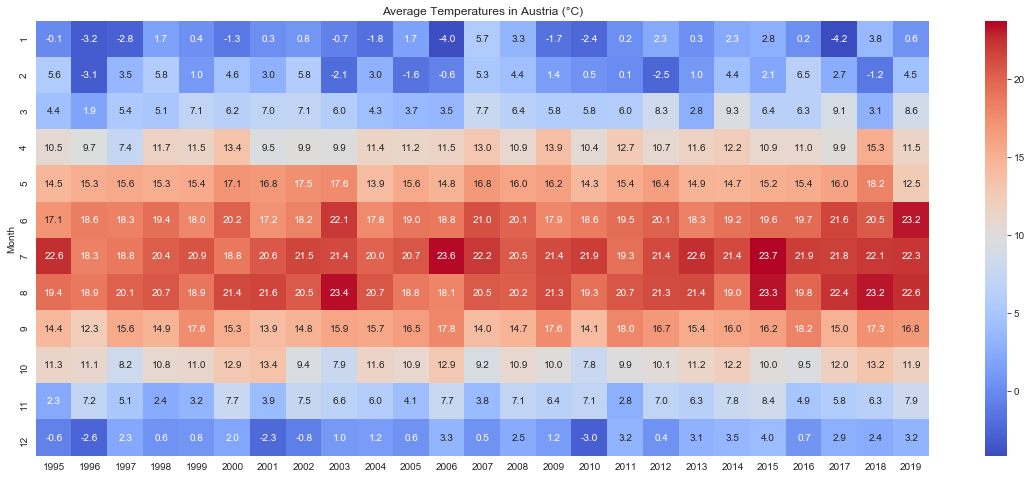

In [120]:
plt.figure(figsize=(20, 8))
sns.heatmap(data = austria_pivoted, cmap='coolwarm', annot = True, fmt=".1f")
plt.ylabel('Month')
plt.xlabel('')
plt.title('Average Temperatures in Austria (°C)')
plt.show();